In [1]:
%load_ext autoreload
%autoreload 2

In [83]:
import numpy as np
from data_process.shadow_render import render_shadow
import matplotlib.pyplot as plt

import torch
from ssn import ssn_dataset
from torchvision import transforms, utils
import numpy as np
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Testing relative vectors

In [84]:
# generate ibls(rotating around)
def to_mask(img):
    img = (img[:,:,0] + img[:,:,1] + img[:,:,2])/3.0
    img = img/np.max(img)
    return img

# relative_vec = np.array([0.108, 2.64, 1.8])
# ibl_img = to_mask(render_shadow(relative_vec))

# Render predictions  

In [85]:
from tqdm import tqdm
from PIL import Image
from ssn.ssn_dataset import Mask_Transform, IBL_Transform, ToTensor
import os 
def show_np(img, title):
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.title(title)
    plt.show()

def to_one_batch(img_tensor):
    c,h,w = img_tensor.size()
    return img_tensor.view(1,c,h,w)

def to_numpy(one_batch):
    return one_batch[0].detach().cpu().numpy().transpose((1,2,0))

def real_to_mask(img):
    print(np.max(img))
    h,w,c = img.shape
    mask = np.zeros((h,w,3), dtype=np.uint8)
    mask[:,:,0],mask[:,:,1],mask[:,:,2]  = img[:,:,3], img[:,:,3], img[:,:,3]
    
    print(np.max(mask))
    
    return mask

In [5]:
from ssn.ssn import Relight_SSN

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print("Device: ", device)
model = Relight_SSN(1,1)

Device:  cpu


In [6]:
print(model)

Relight_SSN(
  (in_conv): Sequential(
    (0): Conv2d(1, 31, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(1, 31, eps=1e-05, affine=True)
    (2): ReLU()
  )
  (down_256_128): Conv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_128_128): Conv(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_128_64): Conv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_64_64): Conv(
    (conv): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU()
  

In [7]:
weight_file = os.path.join('weights', 'l1 loss_30-March-04-13-PM.pt')
checkpoint = torch.load(weight_file, map_location=device)    
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
csv_file = "~/Dataset/soft_shadow/train/metadata.csv"
training_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = True)

Dataset initialize spent: 8.830472230911255 ms


In [9]:
dataloader = DataLoader(training_dataset, batch_size=4, shuffle=False, num_workers=32)

In [10]:
from torchvision.utils import make_grid
counter = 0
model.eval()

Relight_SSN(
  (in_conv): Sequential(
    (0): Conv2d(1, 31, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(1, 31, eps=1e-05, affine=True)
    (2): ReLU()
  )
  (down_256_128): Conv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_128_128): Conv(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_128_64): Conv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_64_64): Conv(
    (conv): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU()
  

In [11]:
min_list, max_list = [], []
with torch.no_grad():
    for i, (mask, light, shadow) in tqdm(enumerate(dataloader)):
        I_s, L_t, I_t = mask.to(device), light.to(device), shadow.to(device)
        
        predicted_img, predicted_src_light = model(I_s, L_t)
        break

0it [00:06, ?it/s]


tensor(0.0609)   tensor(3.0153)
0.0   3.0
gt shape:  (256, 256)
[0,1]: 42, [1,2]: 142, [2,3]:1489, [3,4]:63863
[0,1]: 391, [1,2]: 197, [2,3]:64923, [3,4]:25


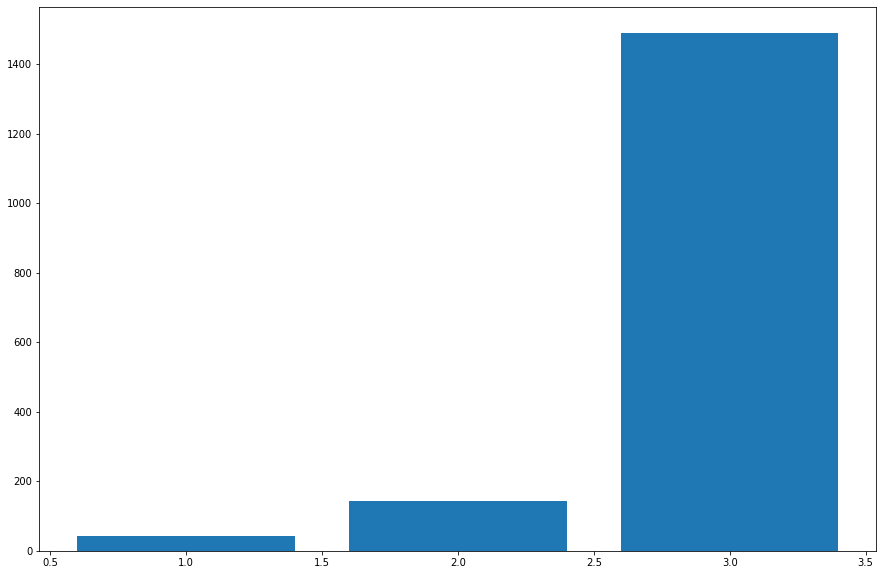

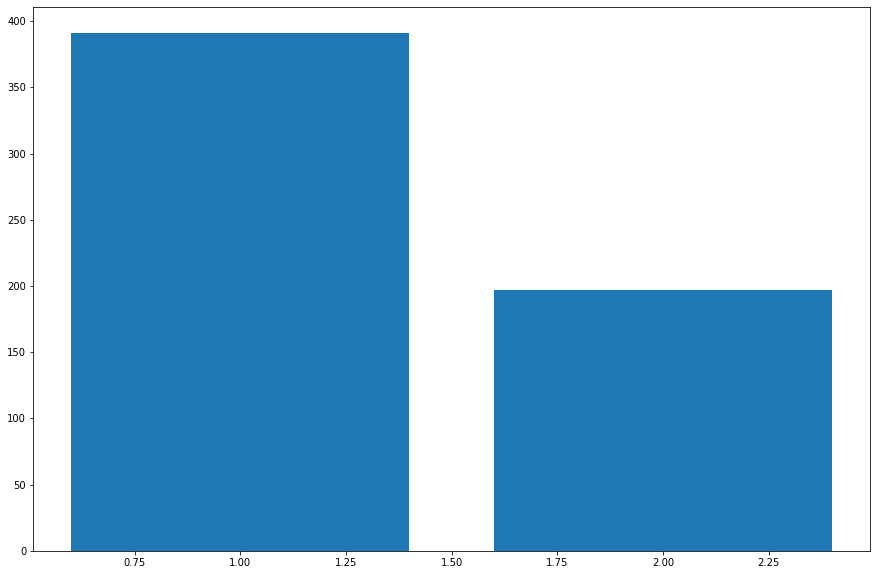

In [80]:
def show_torch(batch, title=''):
    npimg = make_grid(batch).numpy().transpose(1,2,0)
    show_np(npimg, title)

predicted_img_copy = torch.clone(predicted_img)
I_t_copy = torch.clone(I_t)
L_t_copy = torch.clone(L_t)

second = predicted_img_copy[1,:,:,:]
second_gt = I_t_copy[1,:,:,:]

print(torch.min(second), ' ', torch.max(second))
second_np = np.squeeze(second.numpy().transpose((1,2,0)))

second_gt_np = np.squeeze(second_gt.numpy().transpose((1,2,0)))
print(np.min(second_gt_np), ' ', np.max(second_gt_np))
print('gt shape: ', second_gt_np.shape)

# print(np.sum(np.where(second_gt_np == 3.0)))
# print(np.sum(np.where(second_gt_np == 2.0)))
# print(np.sum(np.where(second_gt_np == 1.0)))
# print(np.sum(np.where(second_gt_np == 0.0)))

def print_ranges(input_np):
    range_0_1 = len(np.where((input_np >= 0.0) & (input_np < 1.0))[0])
    range_1_2 = len(np.where((input_np >= 1.0) & (input_np < 2.0))[0])
    range_2_3 = len(np.where((input_np >= 2.0) & (input_np < 3.0))[0])
    range_3_4 = len(np.where((input_np >= 3.0) & (input_np < 4.0))[0])
    print('[0,1]: {}, [1,2]: {}, [2,3]:{}, [3,4]:{}'.format(range_0_1, range_1_2, range_2_3, range_3_4)) 
    return [0.5 + 0.5, 1.5 + 0.5, 2.5 + 0.5, 3.5+ 0.5], [range_0_1, range_1_2, range_2_3, range_3_4]

gt_x_c, gt_h = print_ranges(second_gt_np)
x_c, h = print_ranges(second_np)


plt.figure(figsize=(15,10))
plt.bar(gt_x_c[:-1], gt_h[:-1])
plt.show()

plt.figure(figsize=(15,10))
plt.bar(x_c[:-2], h[:-2])
plt.show()



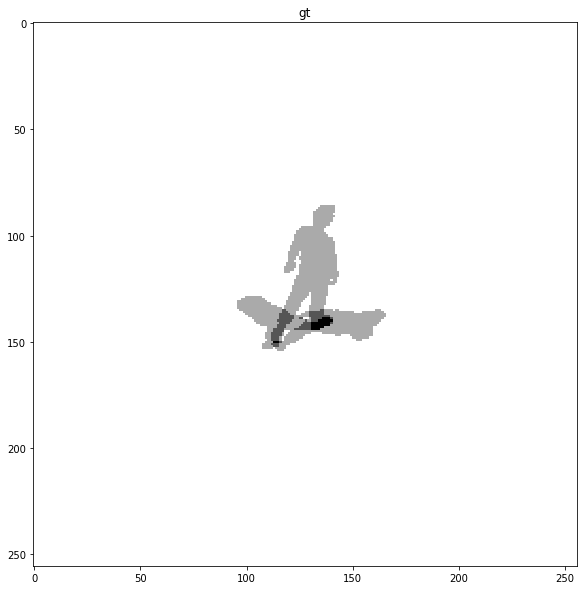

In [51]:
show_torch(I_t_copy[1,:,:,:]/3.0, 'gt')

batch: 0, max: 2.0
batch: 1, max: 3.0
batch: 2, max: 1.0
batch: 3, max: 1.0


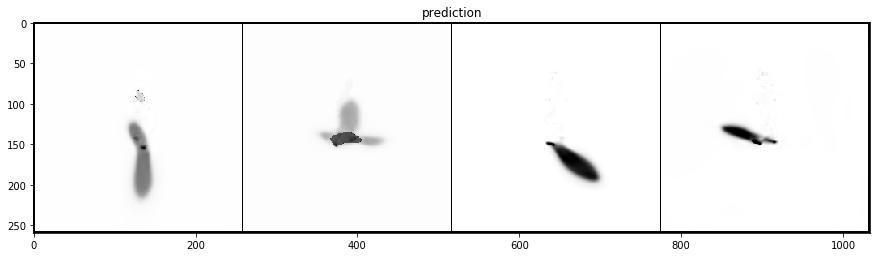

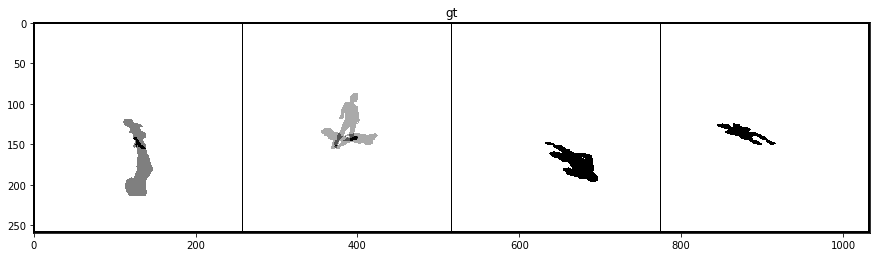

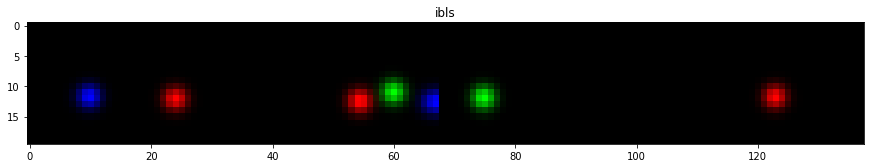

In [81]:
b,c,h,w = predicted_img_copy.shape
for i in range(b):
    print('batch: {}, max: {}'.format(i, torch.max(I_t_copy[i,:,:,:])))
    predicted_img_copy[i,:,:,:] = torch.clamp(predicted_img_copy[i,:,:,:]/torch.max(I_t_copy[i,:,:,:]), 0.0, 1.0)
    I_t_copy[i,:,:,:] = I_t_copy[i,:,:,:]/torch.max(I_t_copy[i,:,:,:])

show_torch(predicted_img_copy, "prediction")
show_torch(I_t_copy, "gt")
show_torch(L_t_copy, "ibls")

In [37]:
print(model.up_stream.out_conv)

Conv(
  (conv): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(1, 1, eps=1e-05, affine=True)
    (2): PReLU(num_parameters=1)
  )
)


In [40]:
prelu = list(model.up_stream.out_conv.conv)[-1]
print(prelu.weight)

remove_prelu = list(model.up_stream.out_conv.conv)[:-1]
remove_prelu = torch.nn.Sequential(*remove_prelu)
model.up_stream.out_conv.conv = remove_prelu

print(model)

Parameter containing:
tensor([-0.0024], device='cuda:1', requires_grad=True)
Relight_SSN(
  (in_conv): Sequential(
    (0): Conv2d(1, 31, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(1, 31, eps=1e-05, affine=True)
    (2): ReLU()
  )
  (down_256_128): Conv(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_128_128): Conv(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_128_64): Conv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU()
    )
  )
  (down_64_64): Conv(
    (conv): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1




0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


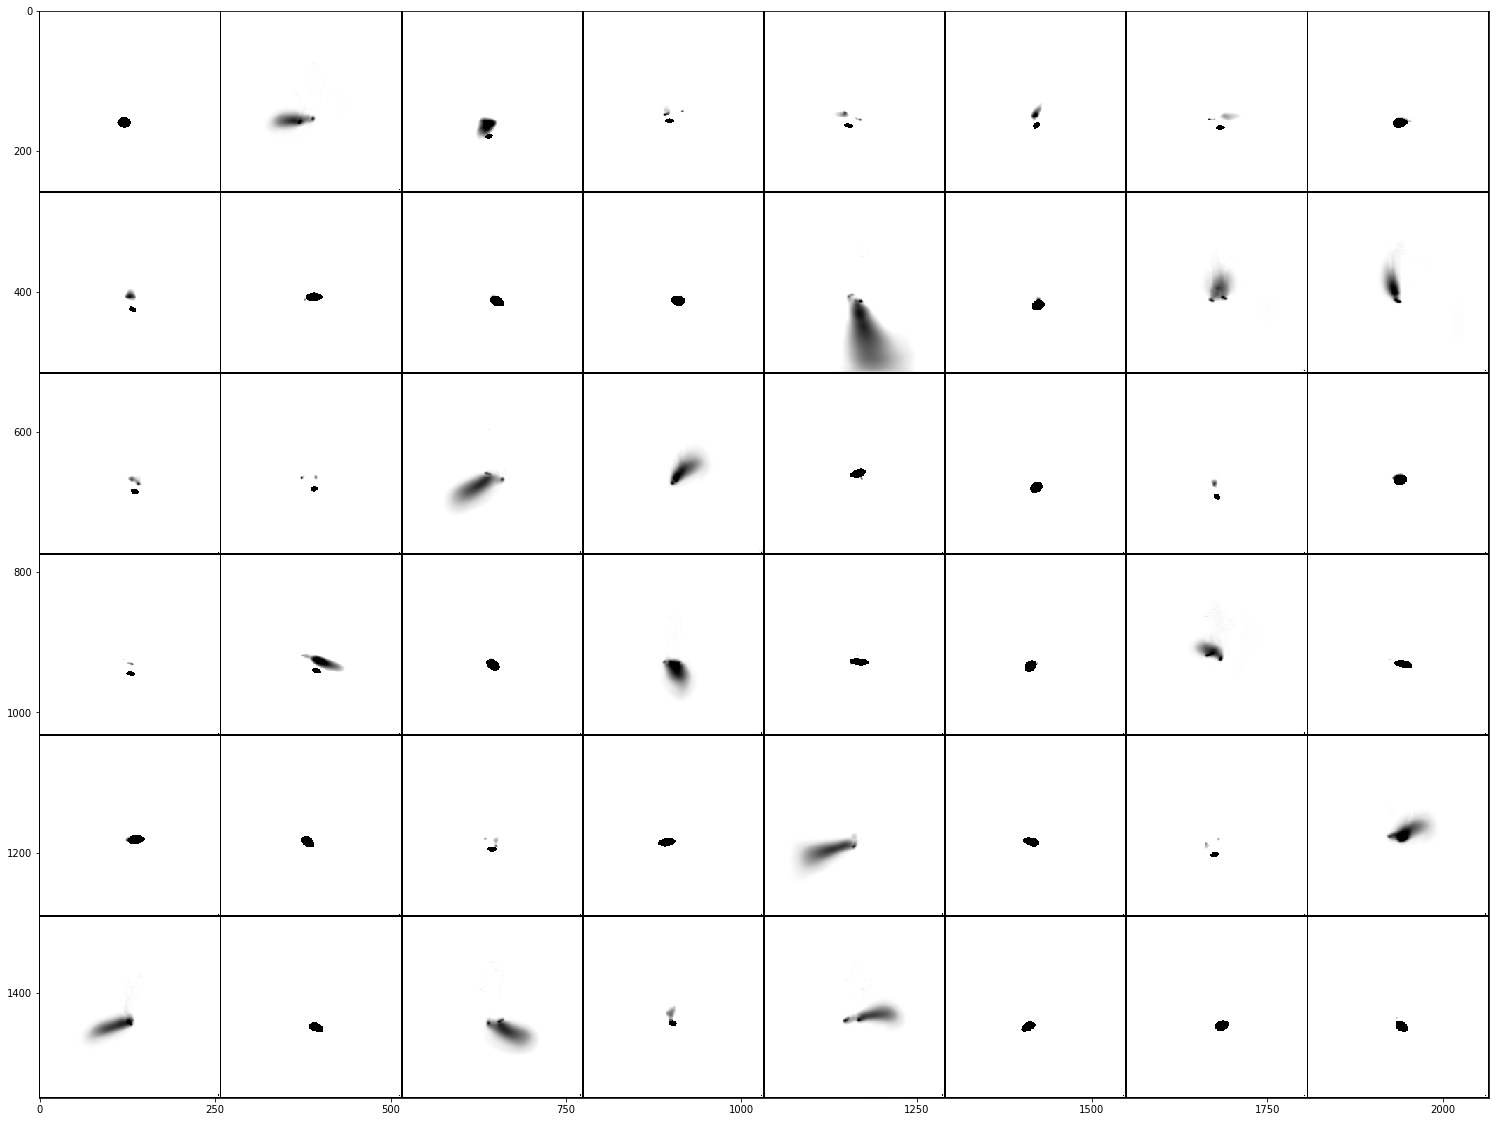




1it [00:15, 15.46s/it]

min: -1056.6312255859375, max: 3.067462205886841


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


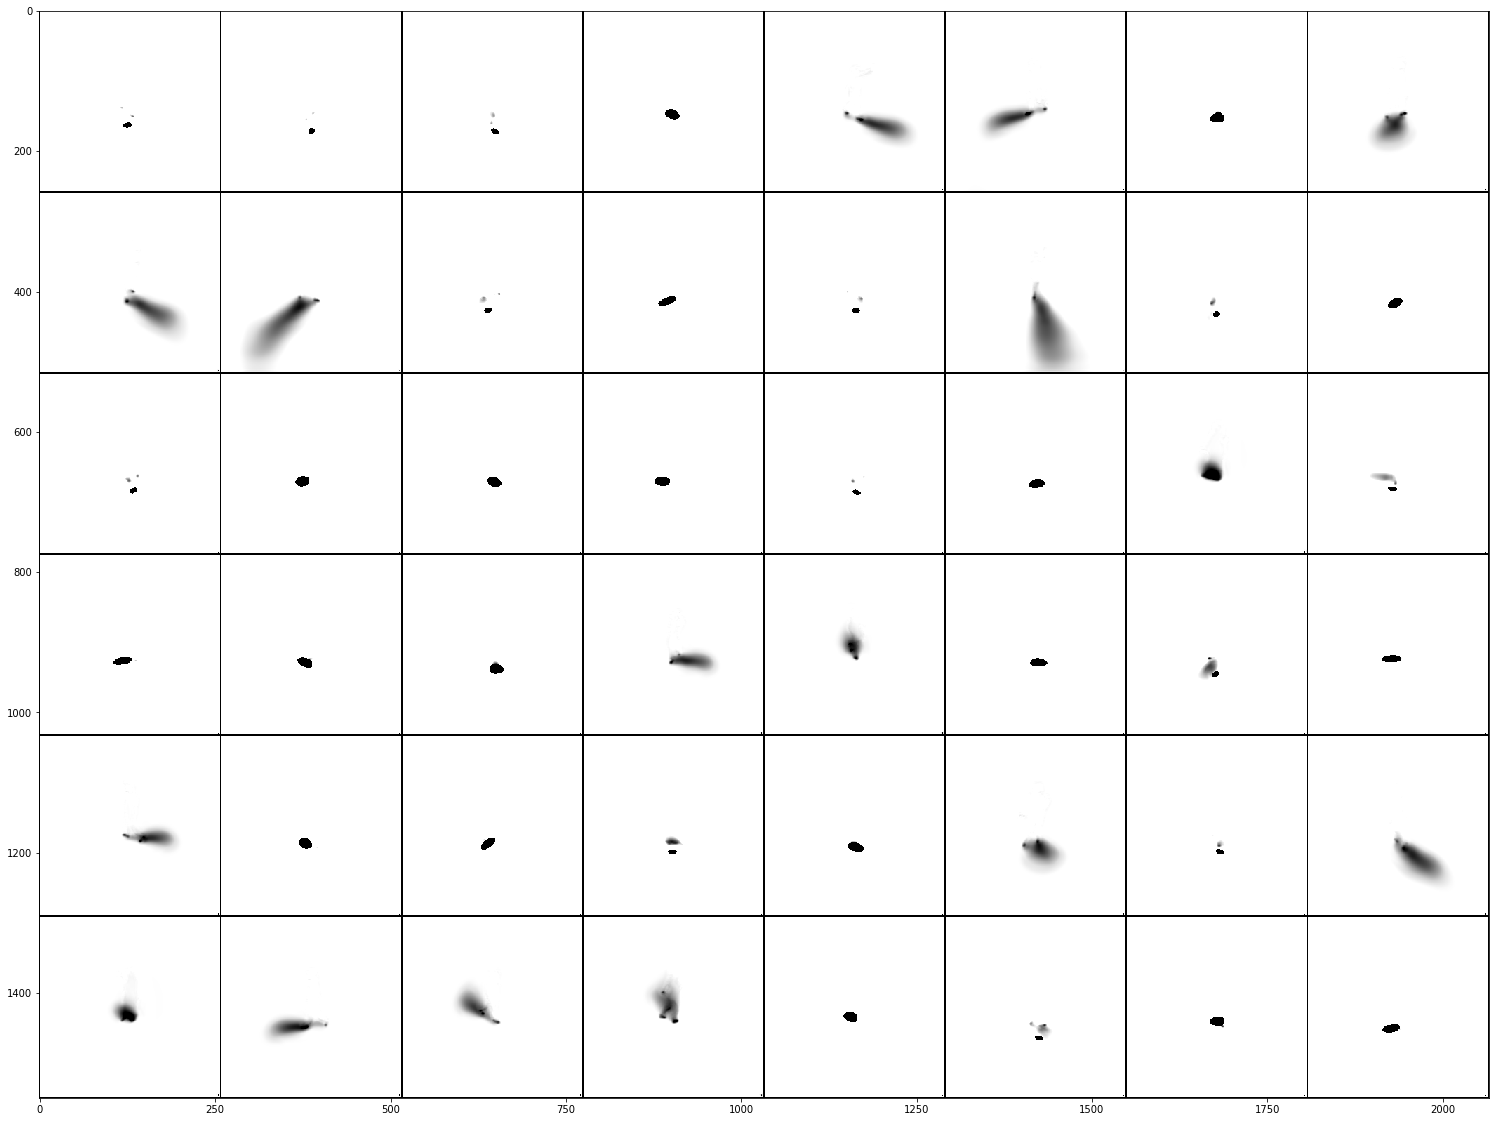




2it [00:17, 11.31s/it]

min: -1558.725341796875, max: 2.09018611907959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


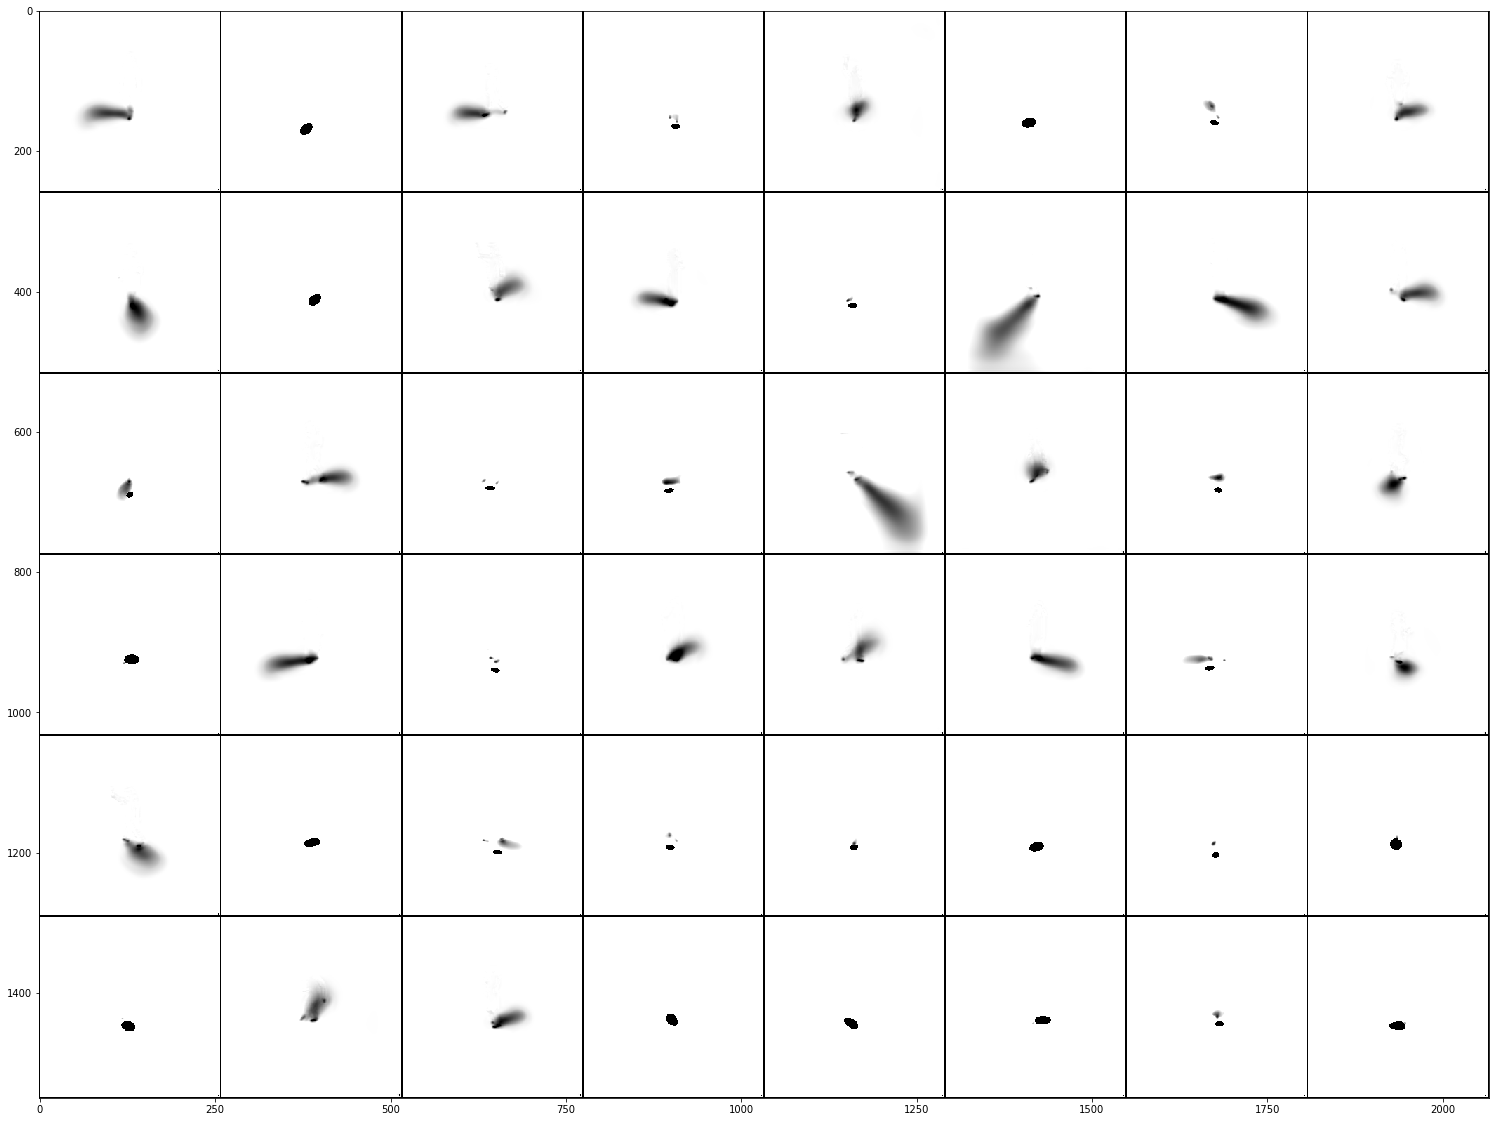

min: -9453.2490234375, max: 1.101568341255188


In [44]:
# prepare to test all results 
model.eval()

min_list, max_list = [], []
with torch.no_grad():
    for i, (mask, light, shadow) in tqdm(enumerate(dataloader)):
        I_s, L_t, I_t = mask.to(device), light.to(device), shadow.to(device)
        predicted_img, predicted_src_light = model(I_s, L_t)
        min_list.append(torch.min(predicted_img))
        max_list.append(torch.max(predicted_img))
        
        show_batch(predicted_img)
        
        first_batch = predicted_img[0:1,:,:,:]
        print('min: {}, max: {}'.format(torch.min(first_batch), torch.max(first_batch)))
        
        
        if i > 1:
            break

In [35]:
min_list = torch.tensor(min_list)
print(torch.min(min_list))

max_list = torch.tensor(max_list)
print(torch.max(max_list))

tensor(-9453.2627)
tensor(5.6822)


min: -9453.2490234375, max: 1.101568341255188
min: 0.0, max: 1.101568341255188


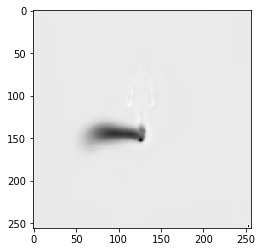

In [59]:
first_batch_np = np.squeeze(first_batch[0].detach().cpu().numpy().transpose((1,2,0)))
print('min: {}, max: {}'.format(np.min(first_batch_np), np.max(first_batch_np)))

first_batch_np[np.where(first_batch_np < 0.0)] = 0.0
print('min: {}, max: {}'.format(np.min(first_batch_np), np.max(first_batch_np)))

plt.figure()
plt.imshow(np.squeeze(first_batch_np), cmap='gray')

# first_batch_np = (first_batch_np - np.min(first_batch_np))
# first_batch_np = first_batch_np/np.max(first_batch_np)

# print('min: {}, max: {}'.format(np.min(first_batch_np), np.max(first_batch_np)))
# plt.figure()
# plt.imshow(np.squeeze(first_batch_np), cmap='gray')


In [67]:
batch_size = 48

id_list = []
for i in range(batch_size):
    if torch.max(predicted_img[i]) > 3.0:
        id_list.append(i)
    
print(id_list)

[1, 5, 9, 24, 33, 37, 39, 40, 43, 44, 45, 47]


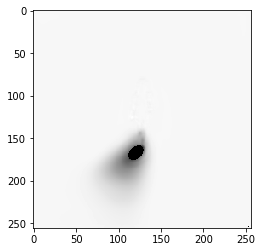

In [78]:
tmp_predicted = predicted_img.detach().cpu().numpy()

tmp_predicted = tmp_predicted[id_list]
sample = np.squeeze(tmp_predicted[0].transpose((1,2,0)))
sample[np.where(sample<0.0)] = 0.0

sample = sample/np.max(sample)

plt.figure()
plt.imshow(sample,cmap='gray')
plt.show()

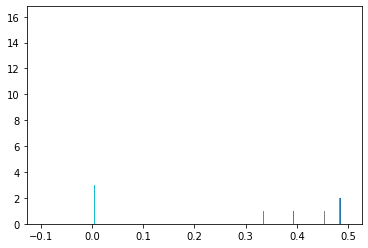

In [81]:
plt.figure()
plt.hist(sample, 20, (-0.1, 0.5))
plt.show()

In [ ]:
print(dataloader_mask.shape)
print(dataloader_light.shape)
dl_mask_np = to_numpy(dataloader_mask)
dl_light_np = to_numpy(dataloader_light)

dl_mask_np = dl_mask_np.reshape(256,256)
dl_light_np = dl_light_np.reshape(16,32)
show_np(dl_mask_np)
show_np(dl_light_np)

h,w = dl_mask_np.shape
testing_np = np.zeros((h,w,3))
testing_np[:,:,0], testing_np[:,:,1], testing_np[:,:,2] = dl_mask_np, dl_mask_np, dl_mask_np
testing_np = testing_np * 255.0

show_np(testing_np)

In [ ]:
import random

output_folder = '/home/ysheng/Documents/adobe_shadow_net/testing_lights/'
prediction_result_folder = '/home/ysheng/Documents/adobe_shadow_net/results/animations/'

# testing_fname = '/home/ysheng/Dataset/soft_shadow/train/bed_0278_normalize/imgs/0000325_mask.png'
# testing_fname = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_short_outfits_genesis8_toulouse_formalmegawardrobepreset14_Base_Pose_Standing_A/imgs/0000000_mask.png'
testing_fname = os.path.join(target_folder, 'imgs/0000355_mask.png')
testing_img = Image.open(testing_fname)

testing_ibl_fnames = [f for f in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, f))]
random.shuffle(testing_ibl_fnames)
counter = 1

img_trnsf = transforms.Compose([
    Mask_Transform(),
    ToTensor()
])
ibl_trnsf = transforms.Compose([
    IBL_Transform(),
    ToTensor()
])
    
for ibl_file in tqdm(testing_ibl_fnames):
    prefix = os.path.splitext(ibl_file)[0]
    out_file = '{}.png'.format(prefix)
    predict_fname = os.path.join(prediction_result_folder, out_file)
    
    tmp_ibl = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_outfits_genesis8_claudia_margita_Base_Pose_Standing_A/imgs/0000100_light.png'
    # ibl_img = Image.open(os.path.join(output_folder, ibl_file))
    
    # mask, shadow = predict(testing_img, ibl_img)
    ibl_tensor = to_one_batch(ibl_trnsf(Image.open(tmp_ibl)))
    

    I_s = torch.cat((dataloader_mask, dataloader_mask), dim=1).to(device)
    L_t = ibl_tensor.to(device)
    
    predict_res, light_res = model(I_s,L_t)
    
    predict_res_np = to_numpy(predict_res)
    mask, shadow = predict_res_np[:,:,0],predict_res_np[:,:,1]
    show_np(mask)
    show_np(shadow)
    
    mask_tensor = to_one_batch(img_trnsf(testing_img))
    I_s = torch.cat((mask_tensor, mask_tensor), dim=1).to(device)
    L_t = ibl_tensor.to(device)
    
    predict_res, light_res = model(I_s,L_t)
    
    predict_res_np = to_numpy(predict_res)
    mask, shadow = predict_res_np[:,:,0],predict_res_np[:,:,1]
    show_np(mask)
    show_np(shadow)
    
    counter += 1
    
    break

# Make animations

In [2]:
from animation import *

ibl_animation = animate_shadow()

ibl_animation.set_begin_row(30)
ibl = ibl_animation.animate_ibl(30, 500)

print(ibl.shape)

(16, 32)
